# PA006 Bank Marketing Strategy

    **Neste ciclo temos o objetivo de encontrar primeiramente as metricas para seguirmos nossa análise.**

## Planejamento da Solução (IOT)

### Input (Entrada)

**Você foi contratado como um cientista de dados consultor, para criar um produto de dados que cria uma segmentação de clientes que direcionará a
estratpegia de marketing e os resultados esperados do seu trabalho de consultoria, são os sequintes:**

    1. Criar uma segmentação de clientes baseado em critérios claros de seleção;
    2. Tornar a segmentação de clientes acessível para o time de operações.
    3. Ensinar o time de operações sobre como usar a sua solução.
    4. Transferir o conhecimento para os Cientistas de Dados da International Bank.
    5. Recomendar 2-3 alavancas de negócio para cada segmento de clientes.

### Output (Saída)

- Ferramentas:
    - Metabase
    - Streamlit


- URL para o time de operação testar

- Download dos dados selecionados

### Tasks (Saída)

- Descrição dos dados
    - Substituição dos NA's.
        
- EDA
    - Análise Univariada.
    - Análise Bivariada
    - Detecção de outliers
    - Seleção de Features
    - Estudo do Espaço
    - Definição do Embedding
    
- Treinamento dos Algoritmos de ML.
    - Análise de Performance
    - Análise de Clustering
    - Definição dos números de clustering
    
- EDA_Insights.
    - Explicação das características dos segmentos
    
- Tabela para armazenar os clientes clusterizados.

- Criação do notebook de produção

- Arquitetura da AWS.
    - S3 para armazenar os daos
    - EC2 para armazenar o ETL e a ferramenta de visualização.
    - DB para armazenar a tabela
    - Cronjob
    - Papermil
 

**Descrição dos Dados**

CUST_ID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases 

BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFF_PURCHASES : Maximum purchase amount done in one-go

INSTALLMENTS_PURCHASES : Amount of purchase done in installment

CASH_ADVANCE : Cash in advance given by the user

PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently
purchased, 0 = not frequently purchased)

ONEOFF_PURCHASES_FREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASES_INSTALLMENTS_FREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASH_ADVANCE_FREQUENCY : How frequently the cash in advance being paid

CASH_ADVANCE_TRX : Number of Transactions made with "Cash in Advanced"

PURCHASES_TRX : Numbe of purchase transactions made

CREDIT_LIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRC_FULL_PAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

# 0.0 Imports

In [33]:
import numpy   as np
import pandas  as pd
import seaborn as sns

#import umap.umap_ as umap

from matplotlib          import pyplot               as plt
from plotly              import express              as px
from sklearn             import cluster              as c
from sklearn             import metrics              as m
from sklearn.metrics     import davies_bouldin_score as db


from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [47]:
# load data
df_raw = pd.read_csv( 'data/raw/CC GENERAL.csv' )

# 1.0 Data Description

In [49]:
df1 = df_raw.copy()

## 1.1. Columns Rename

In [50]:
df1.columns = df1.columns.str.lower()
df1.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 1.2. Data Dimensions

In [51]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 8950
Number of cols: 18


## 1.3. Data types

In [52]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [53]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5. Replace NA

In [55]:
df1 = df1.dropna( subset=['minimum_payments','credit_limit'] )
# Por termos como objetivo aqui apenas encontrar uma métrica e analisar nosso conjunto de dados
# desconsiderei os NA's.
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )
# Mostrando a relevancia dos valores NA's excluidos = 0.04

Removed data: 0.04


In [56]:
df1.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [10]:
# Encontramos cerca de 313 customers com valores Na's em pagamento minimo da fatura e 1 cliente sem limite de credito.
# optei em não descartar esses clientes.

#df1 = df1.fillna(0) # substituindo valores NaN por zero

## 1.6. Change dtypes

No changes to be made.

## 1.7. Descriptive Statistics

Cycle 2

# 2.0 Feature Engineering

In [20]:
df2 = df1.copy()

# 3.0 Filtragem de Variáveis

In [21]:
df3 = df2.copy()

# 4.0 EDA (Exploratory Data Analysis)

In [22]:
df4 = df3.copy()

# 5.0 Data Preparation

In [15]:
df5 = df4.copy()

# 6.0 Feature Selection

In [57]:
# dropando a coluna "cust_id" → Neste momento ela não é importante para a análise
cols_drop = ['cust_id'] 
X = df1.drop( cols_drop, axis=1 ) # usado apenas no ciclo 01 para obtençao da métrica
# X = df1.drop( columns=cols_drop ) método alternativo

In [84]:
df1.head(3)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.0,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12


In [81]:
# Analisando apenas duas features 
X = X.loc[:, ['balance', 'credit_limit']]

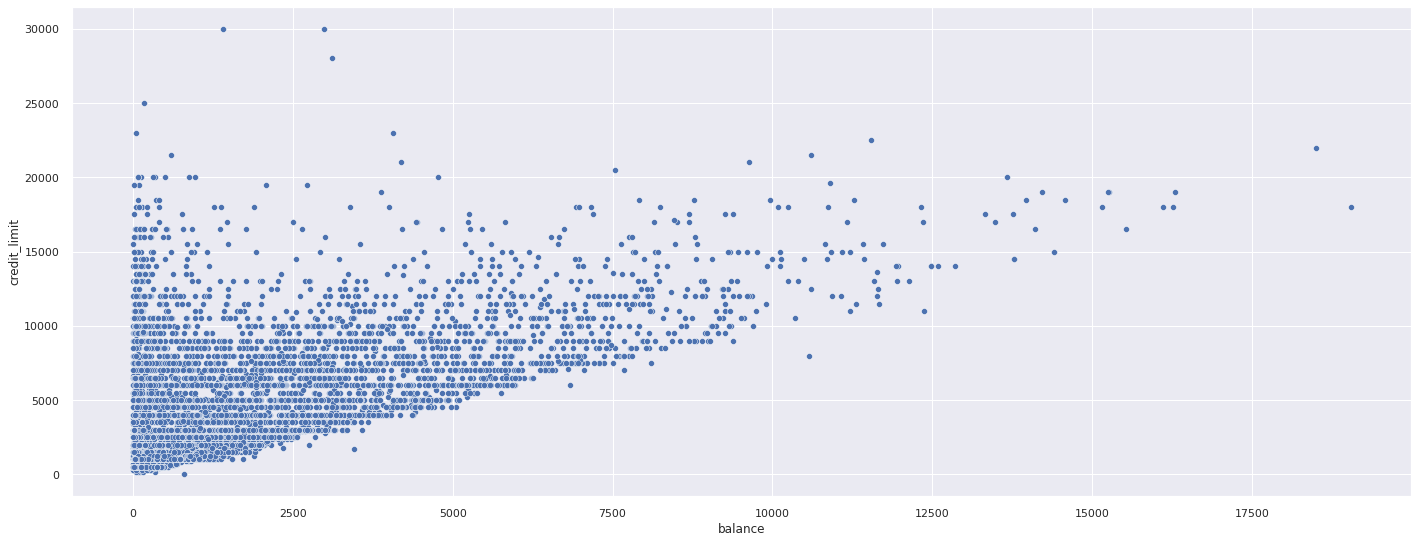

In [87]:
sns.scatterplot( x='balance', y='credit_limit', data=X) ;
# Vemos que os dados estão muito misturados entre eles mesmo

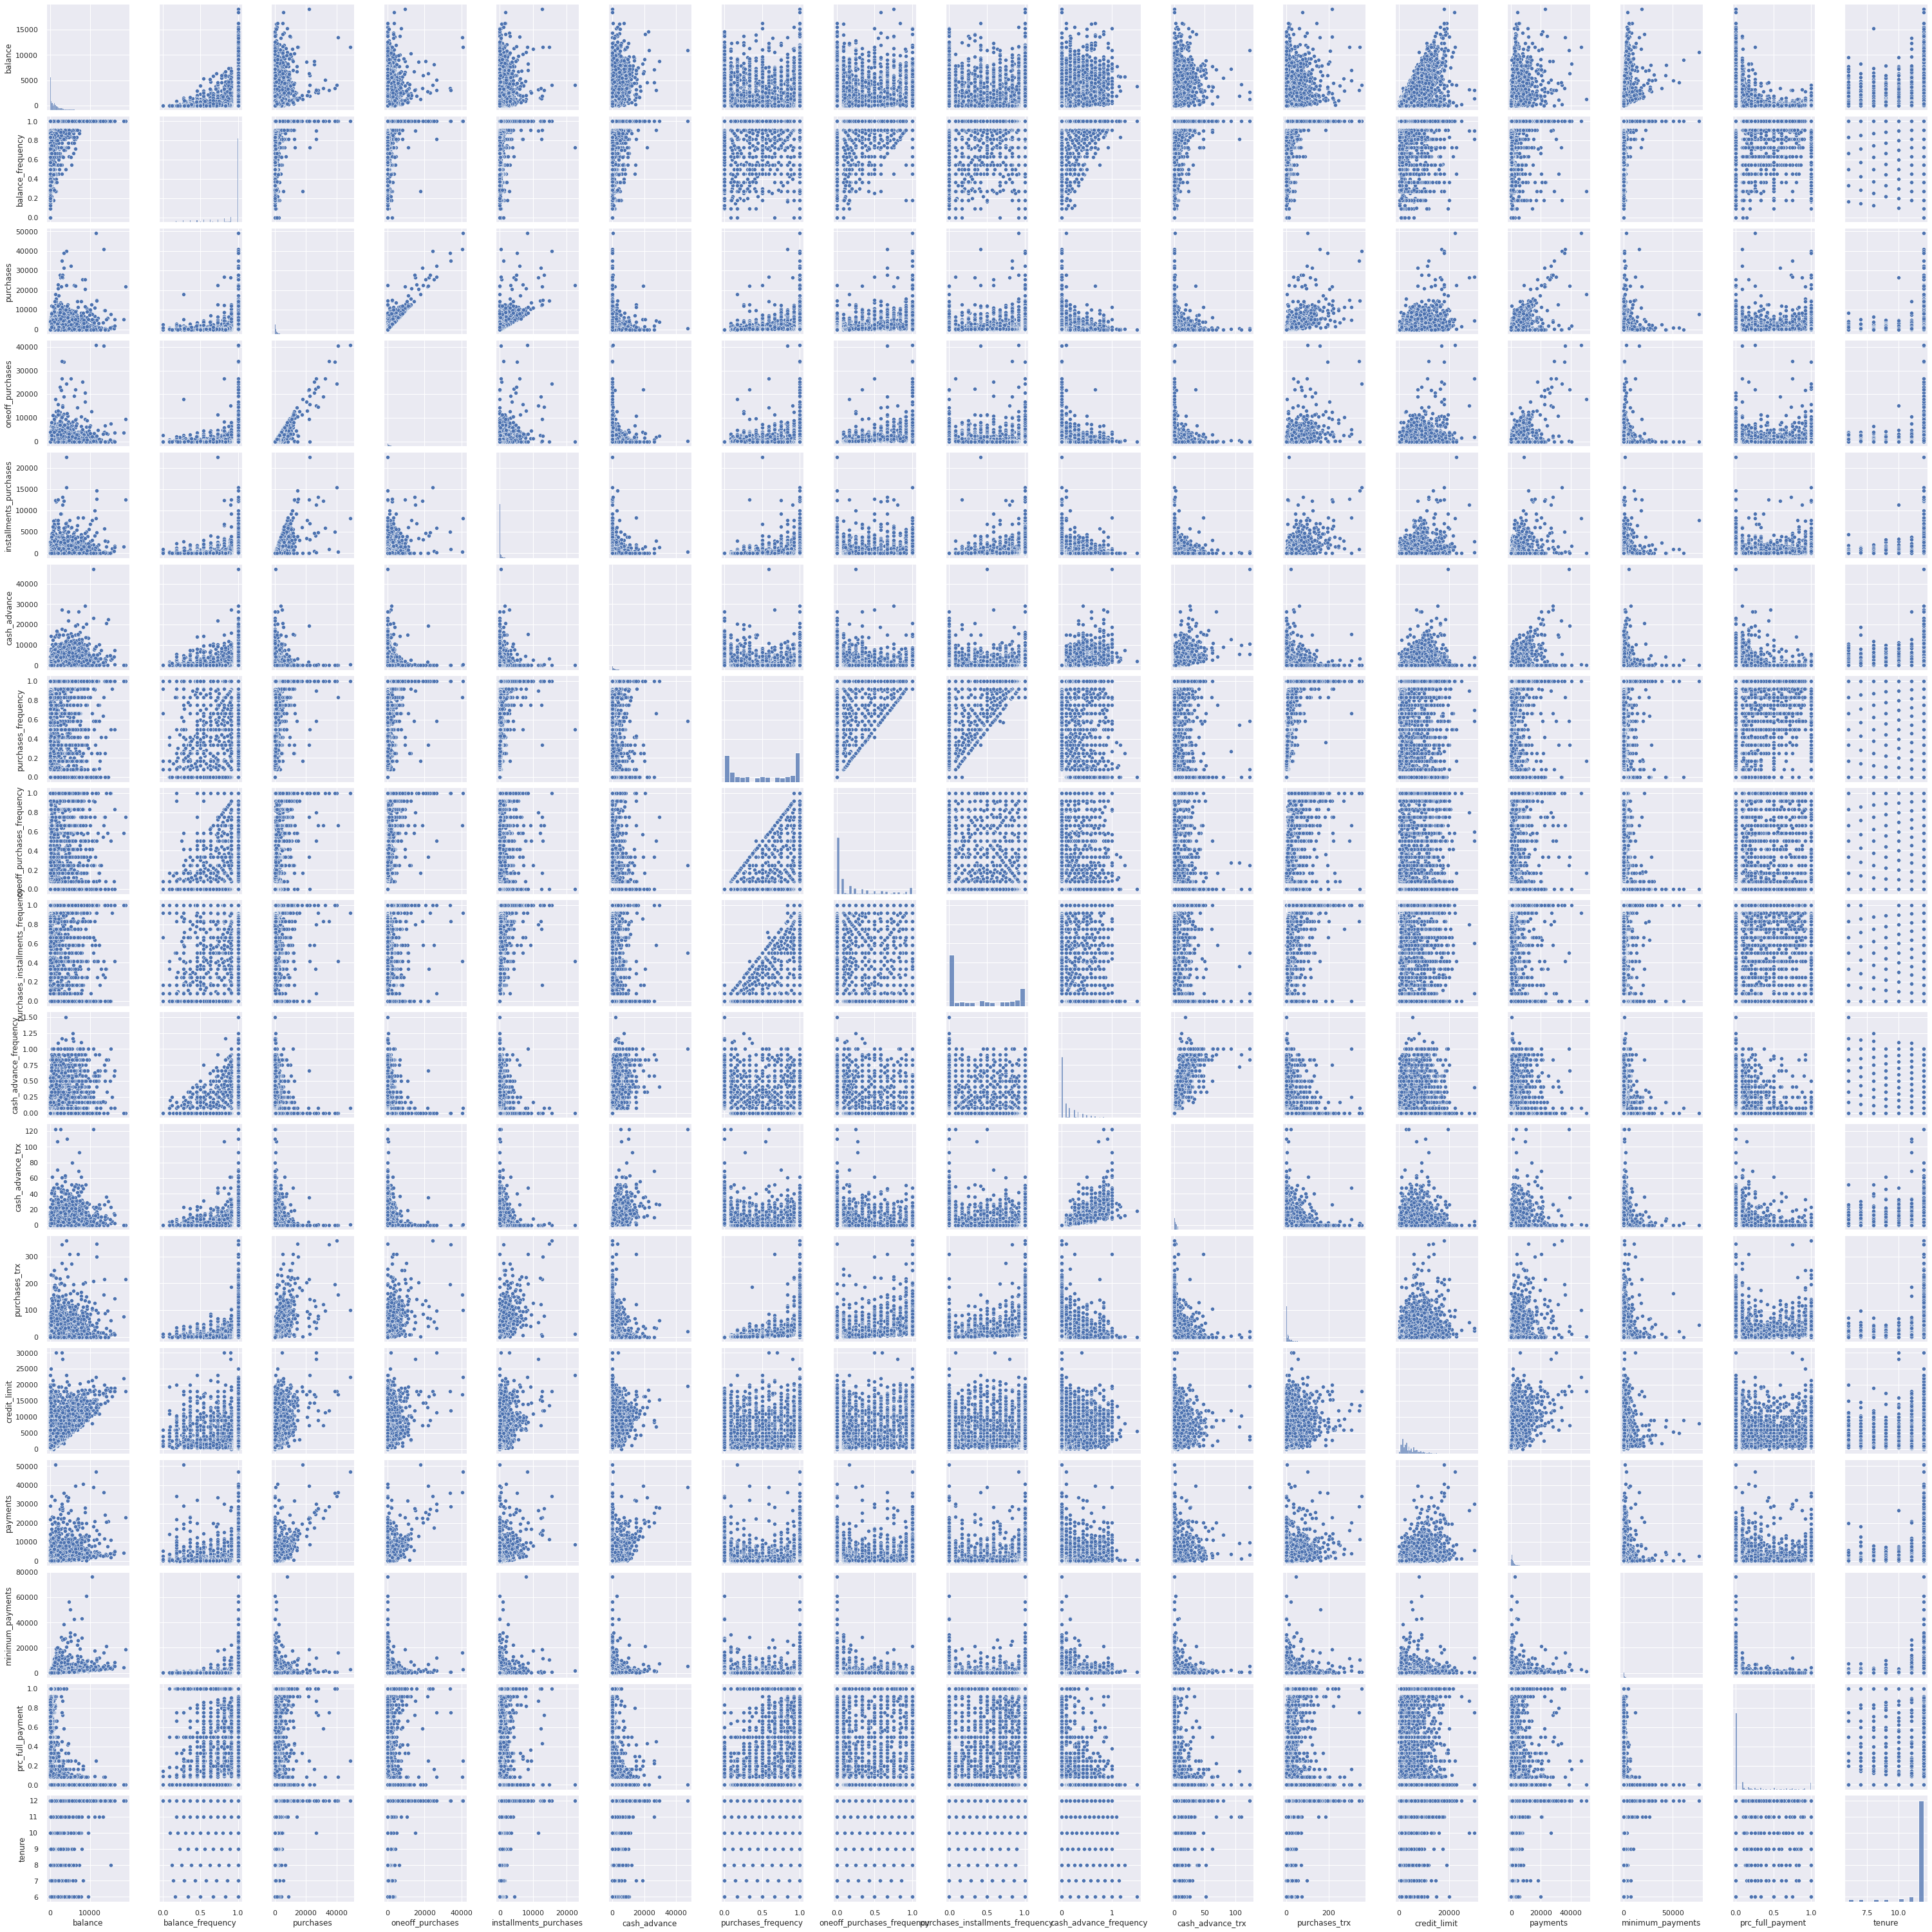

In [88]:
sns.pairplot(df1)


# 7.0 Hyperparameter Fine-Tunning

In [24]:
#df7 = df1.copy()

## 7.1. K-Means

In [70]:
#from sklearn import clustering
clusters = [2, 3, 4, 5, 6, 7, 8 ]

silhouette_list = []
davies_list = []

for k in clusters:
    # Model definition
    kmeans_model = c.KMeans( n_clusters=k )
    
    # model training
    kmeans_model.fit( X )
    # X é o df
    
    # model predict
    labels = kmeans_model.predict( X )
    # agrupando o cluster
    
    # model performance
    sil = m.silhouette_score( X, labels )
    dav = m.davies_bouldin_score( X, labels ) #analisando a métrica 
    
    silhouette_list.append( sil )# Append listas para plotagem do gráfico
    davies_list.append( dav )
    #print( sil )
    
    

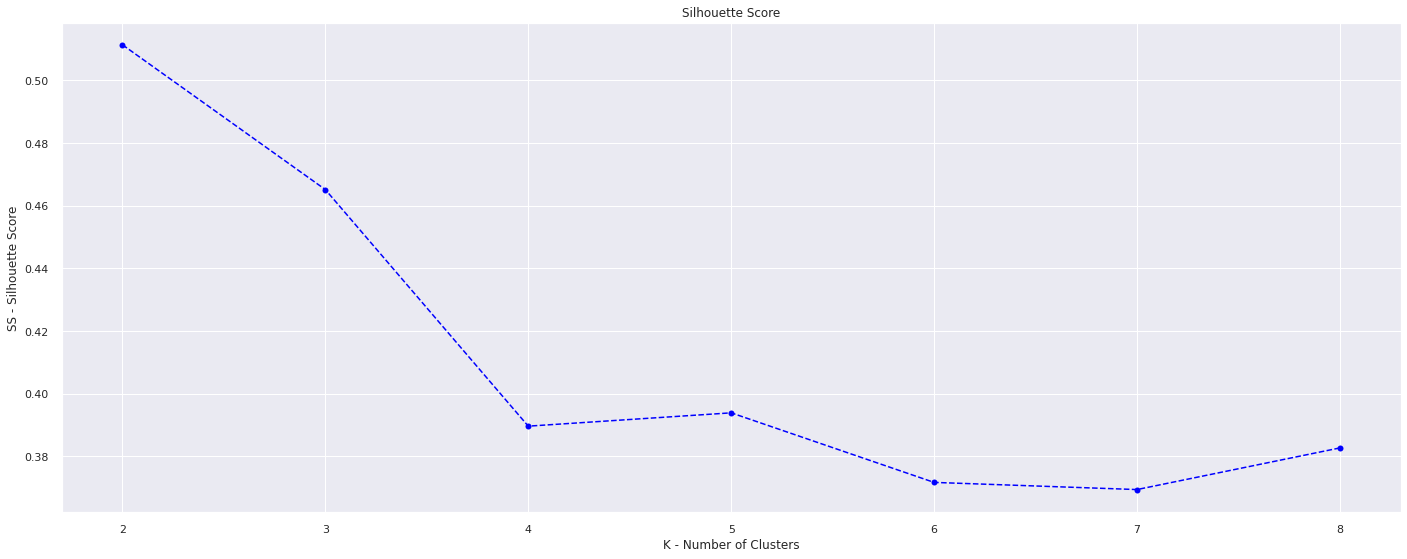

In [71]:
plt.plot( clusters, silhouette_list, linestyle='--', marker='o', color='blue' );
plt.xlabel('K - Number of Clusters')
plt.ylabel('SS - Silhouette Score')
plt.title('Silhouette Score');

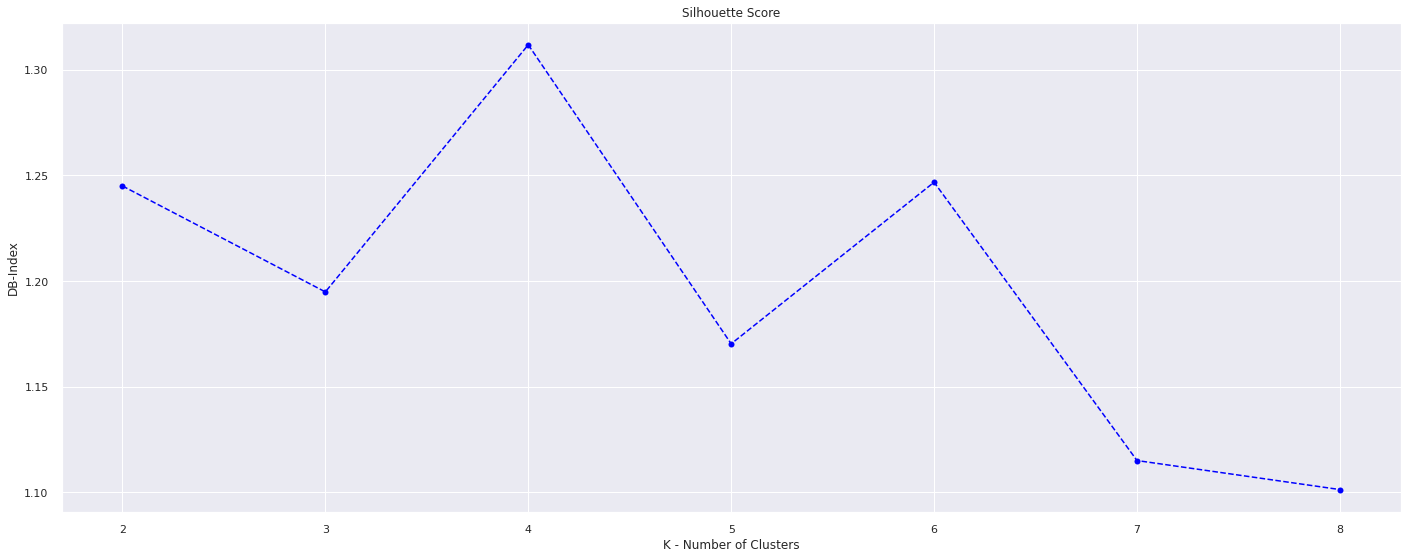

In [72]:
plt.plot( clusters, davies_list, linestyle='--', marker='o', color='blue' );
plt.xlabel('K - Number of Clusters')
plt.ylabel('DB-Index')
plt.title('Silhouette Score');

## 7.1 Silhouette Analysis

IndexError: index 3 is out of bounds for axis 0 with size 3

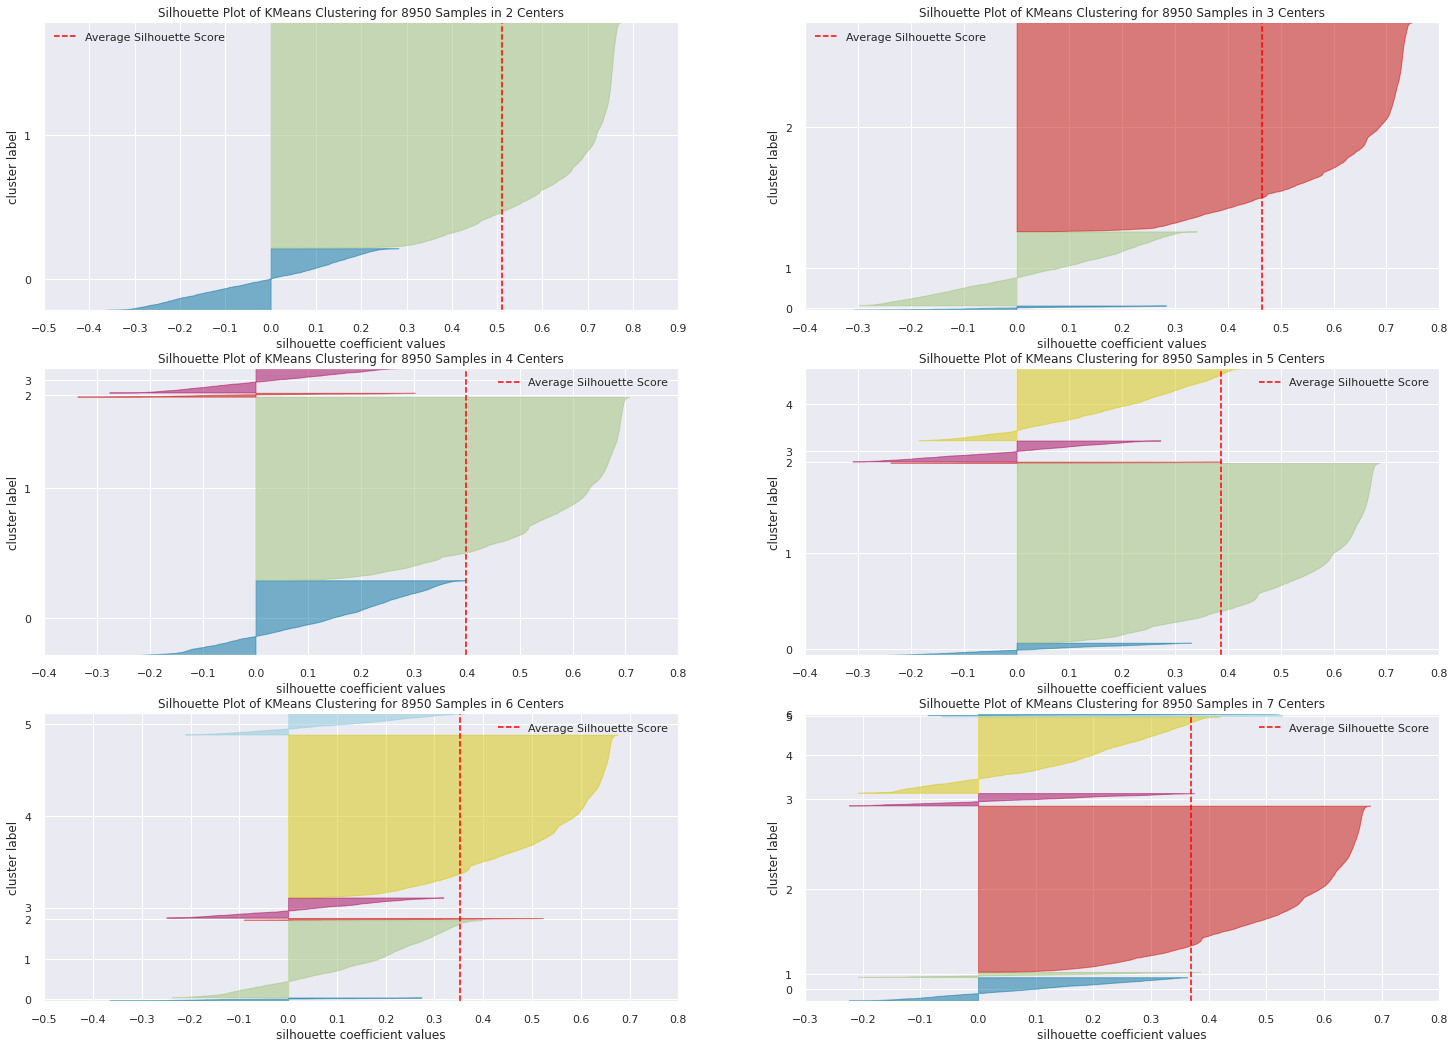

In [78]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    labels = kmeans.labels_
    db(X, labels)
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( df7 )
    visualizer.finalize();

## 7.2 DBscan Analysis

In [31]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import davies_bouldin_score as db

In [34]:
# No DB-index procuramos os cluster mais próximos de zero.
# Esse índice significa a 'similaridade' média entre os clusters, 
#em que a similaridade é uma medida que compara a distância entre 
#os clusters com o tamanho dos próprios clusters.
# Um índice Davies-Bouldin mais baixo está relacionado a um modelo com melhor separação entre os clusters.

kmeans = c.KMeans(n_clusters=3, random_state=1).fit(df7)
labels = kmeans.labels_
db(df7, labels)

1.1904352423164577

In [ ]:
# Nesse ponto, temos uma métrica muito alta no DB-scan que significa uma similiaridade muita baixa entre os Clusters

# 8.0 Model Training

In [35]:
df8 = df7.copy()

## 8.2. Cluster Validation

In [ ]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( df7, labels, metric='euclidean' ) ) )

# 9.0 Cluster Analysis

In [17]:
df9 = df1.copy()

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

## 9.1. Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit(df7)
visualizer.finalize()

## 9.2 2d Plot

In [ ]:
df_viz = df9.drop( columns='cust_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.3 UMAP

In [ ]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( df7 )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profile

In [ ]:
df9.head()

In [ ]:
# Number of customer
df_cluster = df9[['cust_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['cust_id'] / df_cluster['cust_id'].sum() )

df_cluster

# 10.0 Deploy

In [ ]:
df10 = df9.copy()